In [4]:
# Dataset and Dataloader

# Dataset is for accessing and processing single instances of data

# Dataloader pulls instances from the Dataset, collects them in batches, and returns them to input into your training loop

# Torchvision contains ImageFolder, allowing you to create a dataset from images on your filesystem

# torch.utils.data.random_split allows you to split a dataset into training and validation sets

# To train on GPU, look at Memory Pinning

import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Sandal  Coat  Trouser  Ankle Boot


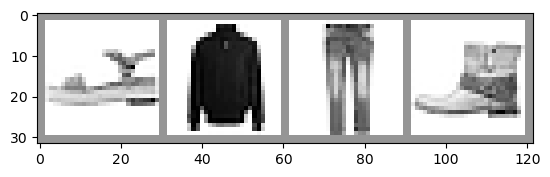

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [7]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[8.3117e-01, 3.3682e-02, 7.5352e-01, 3.6794e-01, 2.0241e-01, 7.5414e-01,
         8.1755e-01, 7.0632e-04, 5.2323e-01, 7.1936e-01],
        [9.9261e-01, 8.7762e-01, 5.5805e-01, 5.0296e-01, 6.5496e-01, 1.0898e-01,
         5.8699e-01, 2.1036e-01, 4.6080e-01, 4.3816e-01],
        [4.9290e-01, 4.4683e-01, 8.6372e-01, 6.0859e-01, 1.3679e-01, 9.6883e-01,
         1.0899e-01, 4.7377e-01, 5.6594e-01, 3.2656e-01],
        [7.3040e-01, 3.5230e-01, 3.9282e-01, 4.4887e-01, 1.9100e-01, 3.1028e-01,
         1.1237e-01, 9.0621e-01, 1.8977e-02, 7.9032e-02]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.3993420600891113


In [8]:
# Optimizers specified in the torch.optim package

# If training on GPU, use model.to(device) to move the model to the GPU before passing it to the optimizer

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)